In [55]:
import matplotlib.pyplot as plt
import csv
import pandas
from matplotlib.backends.backend_pdf import PdfPages
import seaborn
import numpy as np
from pandas.plotting import autocorrelation_plot
seaborn.set()
seaborn.set_style("whitegrid")

The following sets some constants, for comparison

In [2]:
BYTE = 8
GIGA = 1024 * 1024 * 1024
BWM_NG_HEADERS = ["timestamp",
                               "interface", 
                               "bytes_out/s", 
                               "bytes_in/s",                                
                               "bytes_total/s", 
                               "bytes_in", 
                               "bytes_out", 
                               "packets_out/s", 
                               "packets_in/s", 
                               "packets_total/s", 
                               "packets_in", 
                               "packets_out", 
                               "errors_out/s", 
                               "errors_in/s", 
                               "errors_in", 
                               "errors_out "]
BWM_NG_ARGS = {
    "names": BWM_NG_HEADERS,
    "converters": 
           {'timestamp': lambda ts: pandas.to_datetime(ts, unit='s')},
    "sep": ';',
    "header": None
    }

Read the bandwidth measurements:

In [3]:
with open("bw_nfs_measure.csv", "r") as fp:
    df = pandas.read_csv(fp, **BWM_NG_ARGS)
    df = df[df['interface'] == 'ens3']
    df = df[:-1500] # Drop the boring samples at the end 
    df['gbit/s'] =  df['bytes_out/s'] * BYTE / GIGA
    df.set_index('timestamp', inplace=True)

Convert it to a time series and compute rolling medians across it:

In [4]:
ts = pandas.Series(df['gbit/s'])

rolling = ts.rolling(center=False, window=50).median()

Export it as a PDF plot for the report:

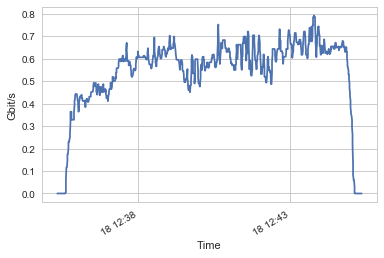

In [5]:
with PdfPages("latex_report/rolling.pdf") as pp:
    ax = rolling.plot()
    #ax.set_ybound(0, 1)
    ax.set_ylabel("Gbit/s")
    ax.set_xlabel("Time")
    pp.savefig()

Compute an autocorrelation plot of the data:

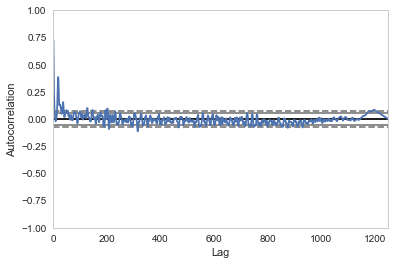

In [6]:
autocorrelation_plot(ts)

Compute the density function of the transfer speed:

Text(0.5,0,'Gbit/s')

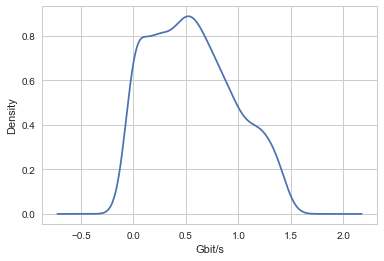

In [7]:
ax = df['gbit/s'].plot.kde()
ax.set_xlabel("Gbit/s")

## Result analysis
The following cells analyse the results of the measurements.

In [8]:
FORMAT_OPTIONS = {'sep': ";", 'header': None, 
                  'names': ["start time", "end time",
                            "workers", "runtime"],
                  "converters": 
                   {'start time': lambda ts: pandas.to_datetime(ts, unit='s'),
                    'end time': lambda ts: pandas.to_datetime(ts, unit='s')},
}

In [9]:
with open("runtimes.hdfs", "r") as fp:
    hdfs_runtimes = pandas.read_csv(fp, **FORMAT_OPTIONS)

First, perhaps most importantly, we need to calculate the standard error mean (in seconds):

In [10]:
def get_errors(result_df):
    return pandas.DataFrame(
        [{'workers': w, 
          'error': result_df[result_df['workers'] == w].sem()['runtime']}
         for w in range(4, 11)])

In [11]:
with open("runtimes.nfs", "r") as fp:
    nfs_runtimes = pandas.read_csv(fp, **FORMAT_OPTIONS)

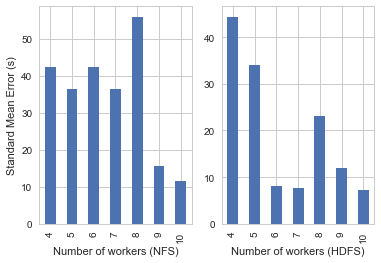

In [12]:
with PdfPages("latex_report/errors.pdf") as pp:
    fig, (axsl, axsr) = plt.subplots(1, 2)
    get_errors(nfs_runtimes).plot.bar("workers", ax=axsl)
    get_errors(hdfs_runtimes).plot.bar("workers", ax=axsr)
    axsl.set_ylabel("Standard Mean Error (s)")
    axsr.set_xlabel("Number of workers (HDFS)")
    axsl.set_xlabel("Number of workers (NFS)")
    
    axsl.legend([])
    axsr.legend([])
    pp.savefig()

Plot the results. Note that the `x_estimator` argument collects multiple data points and adds error bars to the plot!

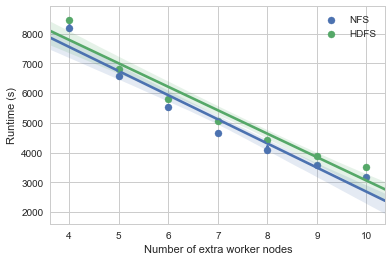

In [13]:
with PdfPages("latex_report/scaling.pdf") as pp:
    fig, ax = plt.subplots(1, 1)
    CHART_OPTIONS = {'x': "workers", 'y': "runtime",
                     'x_estimator': np.mean, 'ax': ax}
    seaborn.regplot(data=nfs_runtimes, label="NFS", **CHART_OPTIONS)
    seaborn.regplot(data=hdfs_runtimes, label="HDFS", **CHART_OPTIONS);
    ax.legend()
    ax.set_xlabel("Number of extra worker nodes")
    ax.set_ylabel("Runtime (s)")
    pp.savefig()

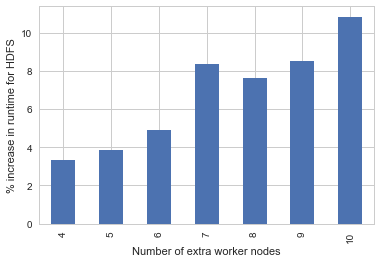

In [14]:
def get_difference(hdfs_df, nfs_df):
    return pandas.DataFrame(
        [{'workers': w, 
          'Difference %': 100 * (hdfs_df[hdfs_df['workers'] == w].mean()['runtime']
             - nfs_df[nfs_df['workers'] == w].mean()['runtime']) / 
          nfs_df[nfs_df['workers'] == w].mean()['runtime']}
         for w in range(4, 11)])

with PdfPages("latex_report/diff_over_workers.pdf") as pp:
    fig, ax = plt.subplots(1, 1)
    get_difference(hdfs_runtimes, nfs_runtimes).plot.bar("workers", ax=ax)
    ax.set_xlabel("Number of extra worker nodes")
    ax.set_ylabel("% increase in runtime for HDFS")
    ax.legend([])
    pp.savefig()

### Network Traffic Analysis
Now, we proceed to read in the network traffic statistics caputured by `bwm-ng`. The bad news are that they constitute a big data problem in and of themselves. :(

In [15]:
NODE_NAMES = ["dataset-download", "project-1"]

In [16]:
node_bw = {}
for node_name in NODE_NAMES:
    with open("bandwidth-measurements-group-2-{}.csv"
              .format(node_name), "rb") as fp:
        df = pandas.read_csv(fp, **BWM_NG_ARGS)
        df = df[df['interface'] == 'ens3']
        node_bw[node_name] = pandas.DataFrame({
            "timestamp": df['timestamp'],
            "gbit/s out": df['bytes_out/s'] * BYTE / GIGA,
            "gbit/s in": df['bytes_in/s'] * BYTE / GIGA})

In [17]:
def slice_time_interval(df, start, end):
    # perform the slicing, and give a copy
    x = (df[(df['timestamp'] >= start) 
            & (df['timestamp'] <= end)]).copy()
    # recompute timestamps to seconds since start
    x['timestamp'] = x['timestamp'] - start
    x.set_index('timestamp', inplace=True)
    return x

In [35]:
def plot_gbps_io(experiment_df, bw_df, size, ax):
    starts = experiment_df[experiment_df['workers'] == size]['start time']
    ends = experiment_df[experiment_df['workers'] == size]['end time']

    in_tss =[]
    out_tss = []
    for start, end in zip(starts, ends):
        xs = slice_time_interval(bw_df, start, end)
        if xs.empty:
            print("Warning! Empty interval {}--{}".format(start, end))
            continue
        in_tss.append(pandas.Series(xs['gbit/s in']))
        out_tss.append(pandas.Series(xs['gbit/s out']))

    # join the time series for the same configuration
    in_ts = pandas.concat(in_tss)
    out_ts = pandas.concat(out_tss)

    in_ts.rolling(center=False, window=1500).median()\
        .plot(label="In", ax=ax)
    out_ts.rolling(center=False, window=1500).median()\
        .plot(label="Out", ax=ax)

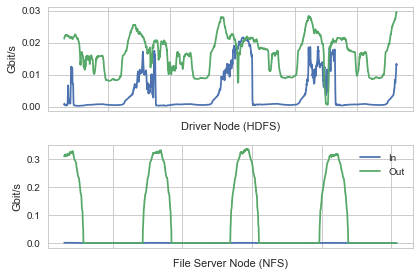

In [66]:
with PdfPages("latex_report/bandwidth_10.pdf") as pp:
    _, axs = plt.subplots(2, 1)
    plot_gbps_io(hdfs_runtimes, node_bw["project-1"], 10, axs[0])
    plot_gbps_io(nfs_runtimes, node_bw["dataset-download"], 10, axs[1])
    axs[0].set_ylabel("Gbit/s")
    axs[1].set_ylabel("Gbit/s")
    axs[0].set_xlabel("Driver Node (HDFS)")
    axs[1].set_xlabel("File Server Node (NFS)")
    axs[1].legend()
    plt.tight_layout()
    pp.savefig()

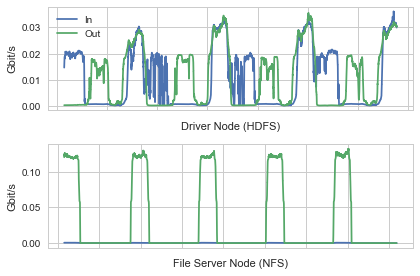

In [68]:
with PdfPages("latex_report/bandwidth_4.pdf") as pp:
    _, axs = plt.subplots(2, 1)
    plot_gbps_io(hdfs_runtimes, node_bw["project-1"], 4, axs[0])
    plot_gbps_io(nfs_runtimes, node_bw["dataset-download"], 4, axs[1])
    axs[0].set_ylabel("Gbit/s")
    axs[1].set_ylabel("Gbit/s")
    axs[0].set_xlabel("Driver Node (HDFS)")
    axs[1].set_xlabel("File Server Node (NFS)")
    axs[0].legend()
    plt.tight_layout()
    pp.savefig()